# Project:  Sequence-based fusion method for identify disease genes.

The identiﬁcation of disease genes from human genome is of great importance to improve diagnosis and treatment of disease. Identifying disease associated genes from the vast number of candidates using experimental methods is an expensive and time consuming task. Hence, the need of computational approaches has been emerged.  

Many machine learning (ML) algorithms have been applied to identify disease genes. 
Most of these methods regarded this problem as binary-class classiﬁcation problem. 

The main chal-lenges are summarized in: 
* Selecting the more complete prior-knowledge about genes to generate the feature vectors.
* Selecting negative data from unknown genes to build and evaluate the classiﬁcation model. 
* Selecting the proper classi-ﬁcation method.

Several machine learning methods have been introduced to identify the ralation between disease and genes. However, these methods mostly differ in the prior knowledge used to construct the feature vector for each instance (gene), the ways of selecting negative data (non-disease genes) where there is no investigational approach to ﬁnd them and the classiﬁcation methods used to make the ﬁnal decision. 

In this project, we use a sequence-based fusion method to identify disease genes using solely the primer structure of the proteins as a prior-knowledge. Four different feature representation methods are used to transform the amino acids sequences to numerical feature vectors. Then, six sequence-based individual classiﬁers using SVM algorithm have been employed. The outputs of these SVM-based predictors were fused using C4.5 algorithm. In addition, a signiﬁcant improvement in the classiﬁcation performance has been also observed by using fusion of SVM-based predictors.

Data: I try to use the Human MicroRNA Disease Database (HMDD) and miR2Disease. 

We first download standard packages.

In [7]:
import numpy as np
from sklearn import svm
import pandas as pd
import csv
import time
from datetime import datetime
from sklearn import tree
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [8]:
import os
print (os.getcwd())

D:\Python code\test\GPU test


## Load the Data
Unknown genes with similar features to the conﬁrmed disease genes could be a candidate disease gene with high probability. The similarity between unknown and known disease genes is based on a variant genomic data which has been generated using high-throughput technologies.
Here, the motivation is that the proteins which lead to similar phenotypes have a higher chance of being connected in the network, in this way, we can prioritize candidate disease genes and render a fewer prioritized list for further investigations using functional similarity data.

In our experiments, we have employed employed the data used by (Yang et al., 2012). This data has 495 known disease genes spanning 383 disease phenotypes, where all the genes have been extracted by combining GENECARD  and  disease gene data. And The protein sequence of each gene has been quarried from Uniprot (Li et al., 2006). 

We load the functional similarity data.

In [9]:

ConnectDate = np.loadtxt('knowndiseasemirnainteraction.txt',dtype=int)-1
# load the similar matrix of the disease
DS1 =np.loadtxt('SimilarMatrix1.txt') 
DS2 = np.loadtxt('SimilarMatrix2.txt')
FS = np.loadtxt(r'miRNASimilarMatrix.txt')


There are three key variables:
* `nm`    = number of miRNA.
* `nd` = number of disease.
* `nc`  = number of miRNA-disease.  

In [10]:
nm = 495 #number of miRNA.
nd = 383 #number of disease.
nc = 5430 #number of miRNA-disease

## Sequence-based fusion method
![Aaron Swartz](https://github.com/TonyNepht/ML-final-project/raw/master/Sequence-based%20fusion%20method.jpg)
As the figure shows, our method for dentifying and prioritizing disease genes consists of four steps: 
* Translate corresponding gene products (proteins) into four numerical feature vectors using four types of protein sequence translator; 
* Selecting negative data from unknown genes; 
* Modeling each feature vector using SVM algorithm;
* Decision Tree algorithm is used to make the ﬁnal decision by fusing the predicting results of the base SVM classiﬁers.
To evaluate the performance of item recommendation, we adopted the leave-one-out evaluation, which has been widely used.

In [11]:
A=np.zeros((nd,nm),dtype=float)  #create matrix 383*495
for i in range(nc):
    A[ConnectDate[i,1], ConnectDate[i,0]] = 1
globalrank_pos = []
localrank_pos = []
predict_0_local = []
accList = []

### Protein sequence translator ___feature extraction
One of the most important challenges in identifying disease gene problem using machine learning algorithm is to extract feature vectors for disease and unknown genes. In this project, we use corresponding gene products (Proteins) to characterize genes.

In this regard, four types of representation methods have been employed to extract the important information of protein inwhich fully encoded, including Normalized Moreau–Broto autocorrelation (NA) (Feng and Zhang, 2000), Geary auto correlation (GA) (Sokal and Thomson, 2006), auto covariance (AC) (Guo et al.,2008), and Moran auto-correlation (MA) (Xia et al., 2010). These methods account for the neighboring effect between amino acids with a certain number of amino acids apart in the sequence using their speciﬁc physicochemical property and make it possible to discover patterns that run through entire sequences. The reason of using these representation methods is to avoid losing important information hidden in the protein sequences. All of these representation methods are based on physicochemical properties of amino acid. Instead of using six or seven physicochemical properties which had been used by the above mentioned representation methods, we have employed twelve physicochemical properties as a descriptor to provide more information about amino acid sequence.

These properties include entropy of formation (EOF) (Chothia, 1992), partition coefﬁcient (PC) (Quinlan, 1996), polarity (POL) (Grantham, 1974), amino acid composition (AAC) (Grantham, 1974), residue accessible surface area in tripeptide (RAS) (Chothia, 1976), transfer free energy (TFE) (Janin, 1979), CC in regression analysis (CC) (Prabhakaran and Ponnuswamy, 1982), hydrophilicity (HY-PHIL) (Hopp and Woods, 1981), polarizability (POL2) (Charton and Charton, 1982), hydrophobicity (HY-PHOB) (Sweet and Eisenberg, 1983), solvation free energy (SFE) (Eisenberg and McLachlan, 1986), and graph shape index (GSI) (Fauchere, et al., 1988), respectively. Min–Max normalization method is used to normalize these physicochemical properties. Table 1 shows the normalized physicochemical properties. It is important to mention that the dimensions of the proposed feature vectors are less than the dimensions of feature vectors which have been presented in the identiﬁcation disease gene researchers recently.


In [12]:
i_nc = 0
def Getgauss_miRNA(adjacentmatrix,nm):
    KM = np.zeros((nm,nm))
    gamaa=1
    sumnormm=0
    for i in range(nm):
        normm = np.linalg.norm(adjacentmatrix[:,i])**2   
        sumnormm = sumnormm + normm  
    gamam = gamaa/(sumnormm/nm)
    for i in range(nm):
          for j in range(nm):
                  KM[i,j]= np.exp (-gamam*(np.linalg.norm(adjacentmatrix[:,i]-adjacentmatrix[:,j])**2))
    return KM

# Getgauss_disease similar matrix
def Getgauss_disease(adjacentmatrix,nd):
    KD = np.zeros((nd,nd))
    gamaa=1
    sumnormd=0
    for i in range(nd):
        normd = np.linalg.norm(adjacentmatrix[i])**2
        sumnormd = sumnormd + normd
    gamad=gamaa/(sumnormd/nd)
    for i in range(nd):
        for j in range(nd):
            KD[i,j]= np.exp(-(gamad*(np.linalg.norm(adjacentmatrix[i]-adjacentmatrix[j])**2)))
    return KD

T3 = time.time()
A[ConnectDate[i_nc,1],ConnectDate[i_nc,0]] = 0  # leave-one-out
KM = Getgauss_miRNA(A,nm)  #Recalculating Gauss Similarity Matrix of miRNA with Adjacency Matrix
KD = Getgauss_disease(A,nd)  #Recalculating Gauss Similarity Matrix of disease with Adjacency Matrix
positive_sample_index = np.argwhere(A == 1)#positive sample
unknown_sample_index =  np.argwhere(A == 0)# negative sample
for i in range(unknown_sample_index.shape[0]):
    if unknown_sample_index[i,0]== ConnectDate[i_nc,1] and unknown_sample_index[i,1]== ConnectDate[i_nc,0]:
        i_1_0 = i         
        break

  

### Selecting negative data
After generating the feature vectors for all genes using repre-sentation methods, it is required to select a negative protein set from the unknown proteins to build a dataset with both positive and reliable negative instances.

In [13]:
def sample_partition(positive_sample_index,unknown_sample_index,FeatureD,FeatureM):    
    positive_sample_FetureD = FeatureD[positive_sample_index[:,0]] 
    positive_sample_FetureM = FeatureM[positive_sample_index[:,1]]
    positive_sample_Feture = np.hstack((positive_sample_FetureD,positive_sample_FetureM))
    unknown_sample_FeatureD = FeatureD[unknown_sample_index[:,0]]
    unknown_sample_FeatureM = FeatureM[unknown_sample_index[:,1]]
    unknown_sample_Feature = np.hstack((unknown_sample_FeatureD,unknown_sample_FeatureM))
    mean=np.mean(positive_sample_Feture,0)
    
    T1=time.time()
    distance=[]
    for i in range(unknown_sample_Feature.shape[0]):
        dis=np.dot(unknown_sample_Feature[i],mean)/ np.linalg.norm(unknown_sample_Feature[i])/np.linalg.norm(mean)
        distance.append(dis)
    T2 = time.time()
    distance = np.array(distance)    
    arg_distance = np.argsort(distance)
    negitive_sample_index = arg_distance[0:nc-1]
    negitive_sample_feature = unknown_sample_Feature[negitive_sample_index]
    test_sample_index = unknown_sample_index  
    test_sample_feature = unknown_sample_Feature
    return positive_sample_Feture,negitive_sample_feature,test_sample_feature
      
#SVM1
T4 = time.time()
positive_sample_DS1_FS,negative_sample_DS1_FS,test_sample_DS1_FS = sample_partition(positive_sample_index,unknown_sample_index,DS1,FS) 
train_sample_DS1_FS = np.vstack((positive_sample_DS1_FS,negative_sample_DS1_FS)) 
X_train = np.zeros((len(train_sample_DS1_FS),6))
X_test = np.zeros((len(test_sample_DS1_FS),6))
Y_value = np.zeros((len(train_sample_DS1_FS),6))


### SVM algorithm
Support Vector Machine (SVM) is a popular and promising method for data classiﬁcation in many application areas.
And we visualize data using PCA.

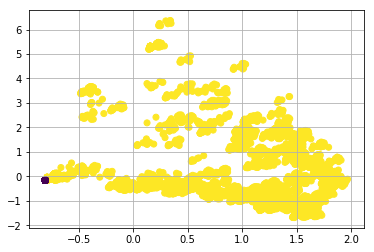

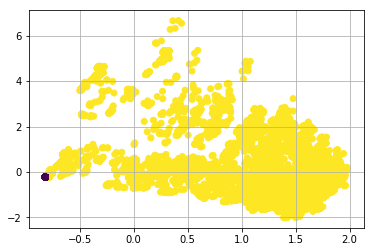

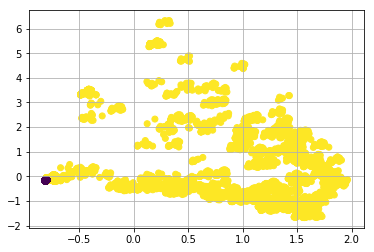

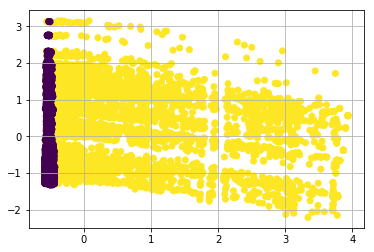

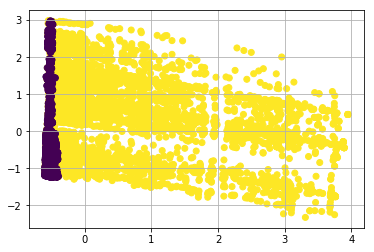

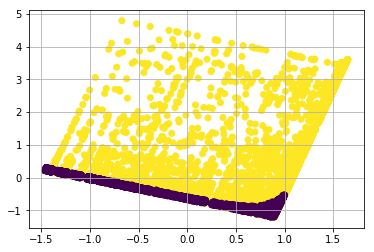

In [14]:

def train_and_predict(train_sample_feature,test_sample_feature,X_train,X_test,Y_value,svmID,accList):
    ncomp = 6
    pca =PCA(n_components=ncomp, svd_solver='randomized',whiten=True ).fit(train_sample_feature)
    Z1 = pca.transform(train_sample_feature) 
    pca =PCA(n_components=ncomp, svd_solver='randomized',whiten=True ).fit(test_sample_feature)
    Z2 = pca.transform(test_sample_feature) 
    clf=svm.SVC()
    train_sample_lable = [1 for j in range(5430)]+[0 for j in range(train_sample_feature.shape[0]-5430)]
    clf.fit(Z1,train_sample_lable)
    test_result =clf.decision_function(Z2)
    X_train[:,svmID] = clf.decision_function(Z1)
    #X_train[:,1] = train_result[:,4]
    Y_value = train_sample_lable
    X_test[:,svmID] = test_result
    
    ncomp = 2
    pca =PCA(n_components=ncomp, svd_solver='randomized',whiten=True ).fit(train_sample_feature)
    Z = pca.transform(train_sample_feature) 
    colors = train_sample_lable
    plt.grid()
    plt.scatter(Z[:,0],Z[:,1],c = colors)
    plt.show()
    
    accList.append(clf.score(Z1,train_sample_lable))
    
    return(X_train,X_test,Y_value,test_result,accList)


(X_train,X_test,Y_value,test_result_DS1_FS,accList) = train_and_predict (train_sample_DS1_FS,test_sample_DS1_FS,X_train,X_test,Y_value,0,accList)
T5 = time.time()

 #SVM2
positive_sample_DS2_FS,negative_sample_DS2_FS,test_sample_DS2_FS = sample_partition(positive_sample_index,unknown_sample_index,DS2,FS)
train_sample_DS2_FS = np.vstack((positive_sample_DS2_FS,negative_sample_DS2_FS)) 
(X_train,X_test,Y_value,test_result_DS2_FS,accList) = train_and_predict (train_sample_DS2_FS,test_sample_DS2_FS,X_train,X_test,Y_value,1,accList)

  #SVM3
positive_sample_KD_FS,negative_sample_KD_FS,test_sample_KD_FS = sample_partition(positive_sample_index,unknown_sample_index,KD,FS)
train_sample_KD_FS = np.vstack((positive_sample_DS1_FS,negative_sample_KD_FS)) 
(X_train,X_test,Y_value,test_result_KD_FS,accList) = train_and_predict (train_sample_KD_FS,test_sample_KD_FS,X_train,X_test,Y_value,2,accList)

  #SVM4
positive_sample_DS1_KM,negative_sample_DS1_KM,test_sample_DS1_KM = sample_partition(positive_sample_index,unknown_sample_index,DS1,KM) 
train_sample_DS1_KM = np.vstack((positive_sample_DS1_KM,negative_sample_DS1_KM)) 
(X_train,X_test,Y_value,test_result_DS1_KM,accList) = train_and_predict (train_sample_DS1_KM,test_sample_DS1_KM,X_train,X_test,Y_value,3,accList)

  #SVM5
positive_sample_DS2_KM,negative_sample_DS2_KM,test_sample_DS2_KM = sample_partition(positive_sample_index,unknown_sample_index,DS2,KM) 
train_sample_DS2_KM = np.vstack((positive_sample_DS2_KM,negative_sample_DS2_KM)) 
(X_train,X_test,Y_value,test_result_DS2_KM,accList) = train_and_predict (train_sample_DS2_KM,test_sample_DS2_KM,X_train,X_test,Y_value,4,accList)

  #SVM6
positive_sample_KD_KM,negative_sample_KD_KM,test_sample_KD_KM = sample_partition(positive_sample_index,unknown_sample_index,KD,KM) 
train_sample_KD_KM = np.vstack((positive_sample_KD_KM,negative_sample_KD_KM)) 
(X_train,X_test,Y_value,test_result_KD_KM,accList) = train_and_predict (train_sample_KD_KM,test_sample_KD_KM,X_train,X_test,Y_value,5,accList)



### Decision Tree algorithm
Since using the same classiﬁer (SVM) to classify the different feature vectors of the same instances, produces some uncertainties and makes some individual errors, a reasonable fusion of these classiﬁers are more likely reduce the overall prediction inaccura-cies and provides better prediction result. It is a powerful solution to solve tough classiﬁcation problems (such as disease gene identiﬁcation) which include dataset with noisy data.

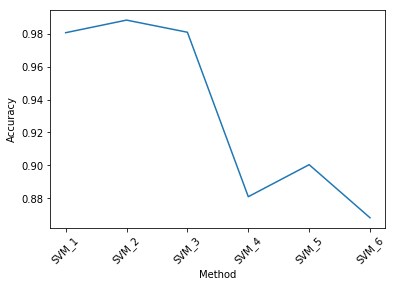

In [15]:
clf = tree.DecisionTreeRegressor(splitter='random',min_samples_split=3,min_samples_leaf = 2)
Y_value = np.zeros((len(train_sample_DS1_FS)))
for i in range(6):
    Y_value +=X_train[:,i]
Y_value = Y_value/6
clf = clf.fit(X_train, Y_value)

predict_0 = clf.predict(X_test)
predict_0_globalrank = pd.Series(predict_0).rank(ascending=False)
globalrank_pos.append(predict_0_globalrank[i_1_0])#global
j=0
for i in range(unknown_sample_index.shape[0]):
    if unknown_sample_index[i,0] == ConnectDate[i_nc,1]:
        predict_0_local.append(predict_0[i]) # render a fewer prioritized list
        j=j+1
    if i==i_1_0:
        i_local=j
predict_0_localrank=pd.Series(predict_0_local).rank(ascending=False) 
localrank_pos.append(predict_0_localrank[i_local-1]) #find the local rank


A[ConnectDate[i_nc,0], ConnectDate[i_nc,1]] = 1 

globalrank_posTemp = np.array(globalrank_pos)

localrank_posTemp = np.array(localrank_pos)

np.savetxt('result.dat',globalrank_posTemp)
np.savetxt('localResult.dat',localrank_posTemp)

names = ['SVM_1','SVM_2','SVM_3','SVM_4','SVM_5','SVM_6']
x = range(len(names))
plt.plot(x,accList)
plt.xticks(x, names, rotation=45)
plt.ylabel ('Accuracy')
plt.xlabel ('Method')
plt.show()

globalrank_posTemp = np.array(globalrank_pos)
localrank_posTemp = np.array(localrank_pos)

np.savetxt('result.dat',globalrank_posTemp)
np.savetxt('localResult.dat',localrank_posTemp)


As we can see from the output graph related to the SVMs and accuracy. SVM_2 have the best performance, which validates the strength of  Gaussian kernel matrix which increase signal to noise. It indicates that by using this method, we can get high accuracy in predicting the potential relation between disease and genes.

### Conclusion

In this work, we use Sequence-based fusion method to identify disease genes. In this way, the amino acid
sequence of the proteins which has been carried out to present the genes (proteins) into four different feature
vectors. To select more likely negative data from candidate genes, the intersection set of four negative sets
which are generated using distance approach is considered. Then, Decision Tree (C4.5) has been applied as a
fusion method to combine the results of six independent state-of the-art predictors based on support vector
machine (SVM) algorithm, and to make the final decision.


### Reference

(Yang, P., et al., 2012.) Positive-unlabeled learning for disease gene identiﬁcation.
Bioinformatics 28, 2640–2647.

(Li, Z.R., et al., 2006.) PROFEAT: a web server for computing structural and
physicochemical features of proteins and peptides from amino acid sequence. Nucleic Acids Res. 34, W32–W37.

